In [139]:
from py_env_train import *

In [116]:
training_unique_name="mse.32.0.01.0.0001.0.25.2.2.8.0.1.64"
data_unique_name="train_data_hourly.pr.['HRES'].['HSAF'].MM.6..spatiotemporal.128.256.2020-07-01T13.2023-05-26T23.no_na.npz"

model_path = PPROJECT_DIR+'/AI MODELS/00-UNET/'+training_unique_name+'.h5'
# Load the trained model
loaded_model = tf.keras.models.load_model(model_path)
# Get the weights of the model
weights = loaded_model.get_weights()

### 2. What are the layers?

In [73]:
# Assuming `loaded_model` is the loaded Keras model
layers = loaded_model.layers
weights = loaded_model.get_weights()

# Print information about each layer
for layer in layers:
    print(layer.name, layer.trainable, layer.output_shape)
    
for weight in weights:
    print(weight.shape)

input_1 True [(None, 128, 256, 7)]
batch_normalization True (None, 128, 256, 7)
conv2d True (None, 128, 256, 32)
conv2d_1 True (None, 128, 256, 32)
max_pooling2d True (None, 64, 128, 32)
batch_normalization_1 True (None, 64, 128, 32)
conv2d_2 True (None, 64, 128, 64)
conv2d_3 True (None, 64, 128, 64)
max_pooling2d_1 True (None, 32, 64, 64)
batch_normalization_2 True (None, 32, 64, 64)
conv2d_4 True (None, 32, 64, 128)
conv2d_5 True (None, 32, 64, 128)
max_pooling2d_2 True (None, 16, 32, 128)
batch_normalization_3 True (None, 16, 32, 128)
conv2d_6 True (None, 16, 32, 256)
conv2d_7 True (None, 16, 32, 256)
max_pooling2d_3 True (None, 8, 16, 256)
batch_normalization_4 True (None, 8, 16, 256)
conv2d_8 True (None, 8, 16, 512)
conv2d_9 True (None, 8, 16, 512)
batch_normalization_5 True (None, 8, 16, 512)
conv2d_transpose True (None, 16, 32, 256)
concatenate True (None, 16, 32, 512)
conv2d_10 True (None, 16, 32, 256)
conv2d_11 True (None, 16, 32, 256)
batch_normalization_6 True (None, 16, 32,

### 3. Gradient map of the last layer:

#### 3.1 On an example tensor of ones

In [91]:
def compute_gradient_map(model, input_image, layer_name):
    grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        layer_output = grad_model(input_image)
    gradients = tape.gradient(layer_output, input_image)
    gradient_map = tf.reduce_sum(gradients, axis=-1)
    gradient_map /= tf.reduce_max(gradient_map)  # Normalize the gradient map
    return gradient_map

input_image=tf.convert_to_tensor(np.ones((1, 128, 256, 7)))
layer_name = 'conv2d_18'  # Replace with the specific layer name from your UNET model
gradient_map = compute_gradient_map(loaded_model, input_image, layer_name)

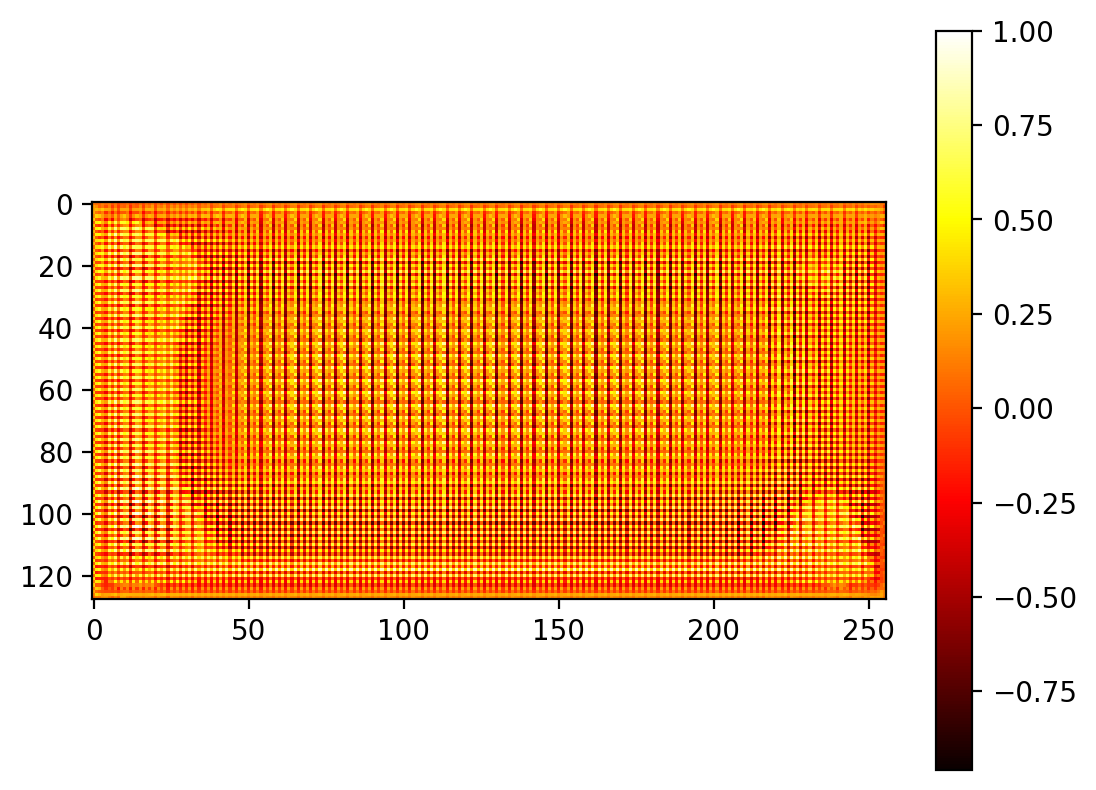

In [92]:
plt.figure(dpi=200)
plt.imshow(gradient_map[0], cmap='hot')  # Access the gradient map from the batch dimension
plt.colorbar()  # Add a colorbar for reference
plt.show()  # Display the plot

#### 3.2 Seasonal Maps

In [141]:
# load the training data
PRODUCTION_DATA=np.load(PRODUCE_FILES+'/'+ data_unique_name)
PRODUCE_X=PRODUCTION_DATA["canvas_x"]

In [164]:
def calculate_seasonal_means(data):
    # Define the boundaries for each season based on the day of the year
    spring_start = 80
    summer_start = 172
    autumn_start = 264

    # Categorize time points into seasons
    spring_indices = np.where((data[:, 20, 80, 2] >= spring_start) & (data[:, 20, 80, 2] < summer_start))
    summer_indices = np.where((data[:, 20, 80, 2] >= summer_start) & (data[:, 20, 80, 2] < autumn_start))
    autumn_indices = np.where((data[:, 20, 80, 2] >= autumn_start) | (data[:, 20, 80, 2] < spring_start))

    # Calculate the mean for each season
    spring_mean = np.mean(data[spring_indices])
    summer_mean = np.mean(data[summer_indices])
    autumn_mean = np.mean(data[autumn_indices])
    winter_mean = np.mean(data[np.concatenate((spring_indices, autumn_indices))])

    return spring_mean, summer_mean, autumn_mean, winter_mean


In [165]:
PRODUCE_X[:, 20, 80, 2]

array([183., 183., 183., ..., 116., 116., 116.], dtype=float32)

In [ ]:
spring_mean, calculate_seasonal_means(PRODUCE_X)